## Coding for the blog entry

In [101]:
import pandas as pd
df = pd.read_csv('kc_house_data.csv')

In [102]:
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [103]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Look at single variable

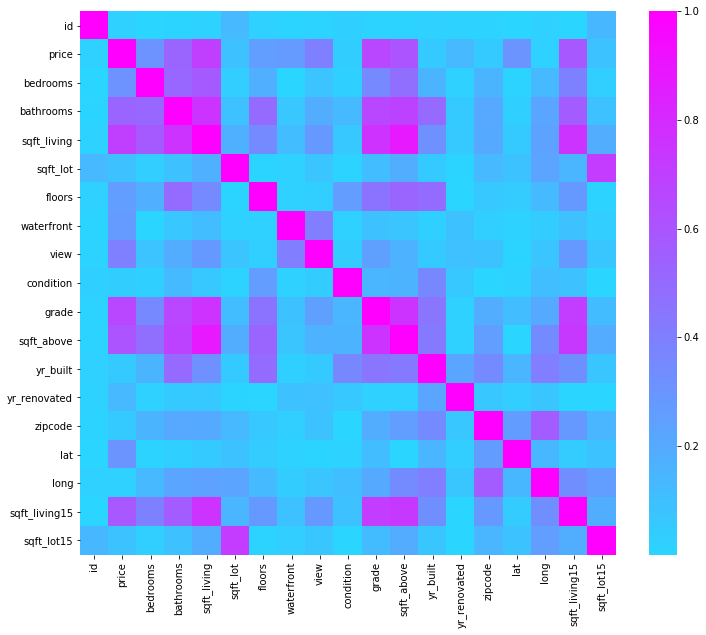

In [64]:
import seaborn as sns

plt.figure(figsize = (12,10))
sns.heatmap(abs(df.corr()), center=0.4, cmap = "cool");

In [70]:
#pd.plotting.scatter_matrix(df, figsize  = [10, 10])
#plt.show()  #takes forever

In [71]:
df.corr()

,price,sqft_living,view,grade
price,1.000000,0.701917,0.395734,0.667951
sqft_living,0.701917,1.000000,0.282532,0.762779
view,0.395734,0.282532,1.000000,0.249727
grade,0.667951,0.762779,0.249727,1.000000


In [67]:
corr_matrix = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_matrix['pairs'] = list(zip(corr_matrix.level_0, corr_matrix.level_1))
corr_matrix.set_index(['pairs'], inplace = True)

corr_matrix.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr_matrix.columns = ['cc']

corr_matrix.drop_duplicates(inplace=True)

corr_matrix[(corr_matrix.cc>.75) & (corr_matrix.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [68]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [73]:
f

,view_1.0,view_2.0,view_3.0,view_4.0
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0
9,0,0,0,0


,price,sqft_living,view,grade
0,221900.0,1180,0.0,7
1,538000.0,2570,0.0,7
2,180000.0,770,0.0,6
3,604000.0,1960,0.0,7
4,510000.0,1680,0.0,8


In [ ]:
# FEATURE SELECTION


import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.01, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

stepwise_selection()

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

regression = LinearRegression()

X = df_preprocessed.drop('price', axis=1)
y = df_preprocessed['price']

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

regression.fit(X, y)
coefficients = dict(zip(X.columns,list(regression.coef_)))
coefficients

{'sqft_living': 165.77787426719772,
 'grade': 94391.47262131516,
 'view_1.0': 169623.2439369283,
 'view_2.0': 115514.33077618912,
 'view_3.0': 197565.04811697436,
 'view_4.0': 592677.9386480608}

In [75]:
# get rid of categories that have high correlation and others.
to_keep = ['price', 'sqft_living', 'view', 'grade',]
df = df[to_keep]
df.head()

# One hot encoding   
df_ohe = pd.get_dummies(df['view'], prefix='view', drop_first=True)
df_preprocessed = df.drop(['view'], axis=1)
df_preprocessed = pd.concat([df_preprocessed, df_ohe], axis=1)

In [93]:
X = df_preprocessed.drop('price', axis=1)
y = df_preprocessed['price']

# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
regression.fit(X, y)
coefficients = dict(zip(X.columns,list(regression.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('\nBaseline r_squared val:', baseline)

 sqft_living: 165.77787426719772
       grade: 94391.47262131516
    view_1.0: 169623.2439369283
    view_2.0: 115514.33077618912
    view_3.0: 197565.04811697436
    view_4.0: 592677.9386480608

Baseline r_squared val: 0.5783505034911783


GRADE GRADE GRADE GRADE GRADE 
Housing Data - Regression Analysis and Diagnostics for Price~grade
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 1.740e+04
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:08:51   Log-Likelihood:            -3.0101e+05
No. Observations:               21597   AIC:                         6.020e+05
Df Residuals:                   21595   BIC:                         6.020e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

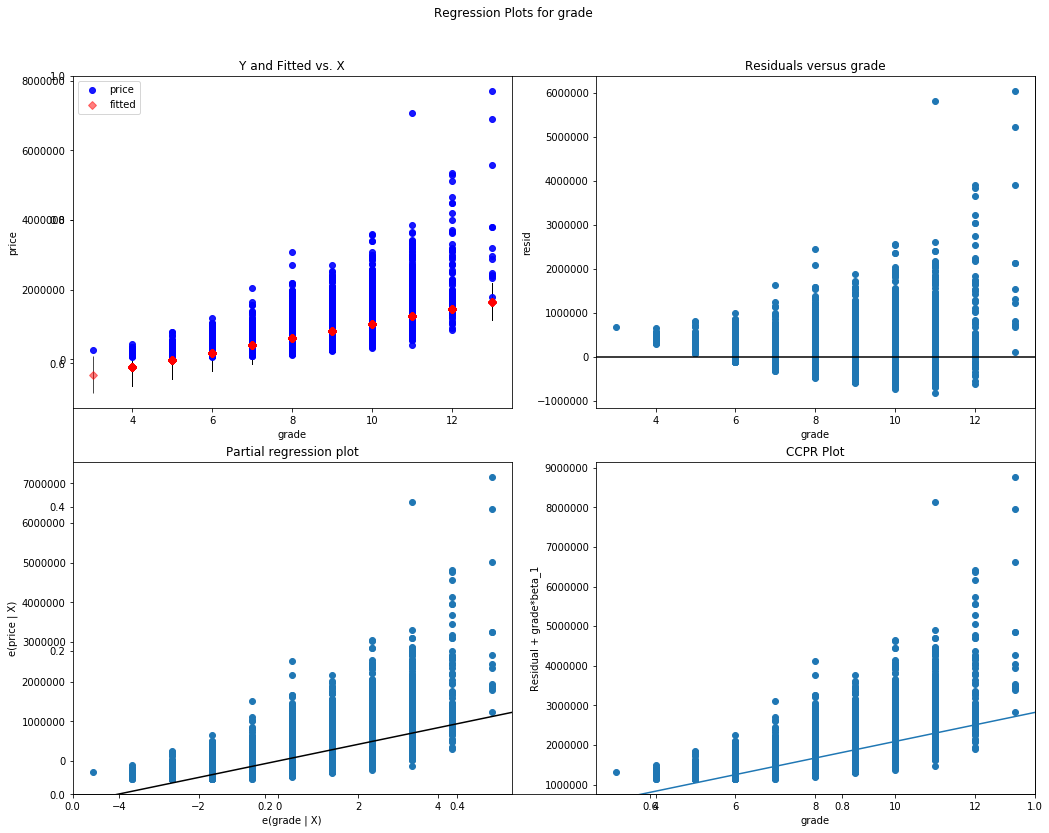

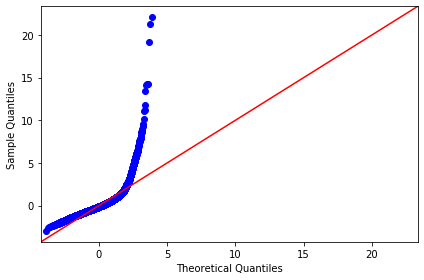

BEDROOMS BEDROOMS BEDROOMS BEDROOMS BEDROOMS 
Housing Data - Regression Analysis and Diagnostics for Price~bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2276.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:08:53   Log-Likelihood:            -3.0631e+05
No. Observations:               21597   AIC:                         6.126e+05
Df Residuals:                   21595   BIC:                         6.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

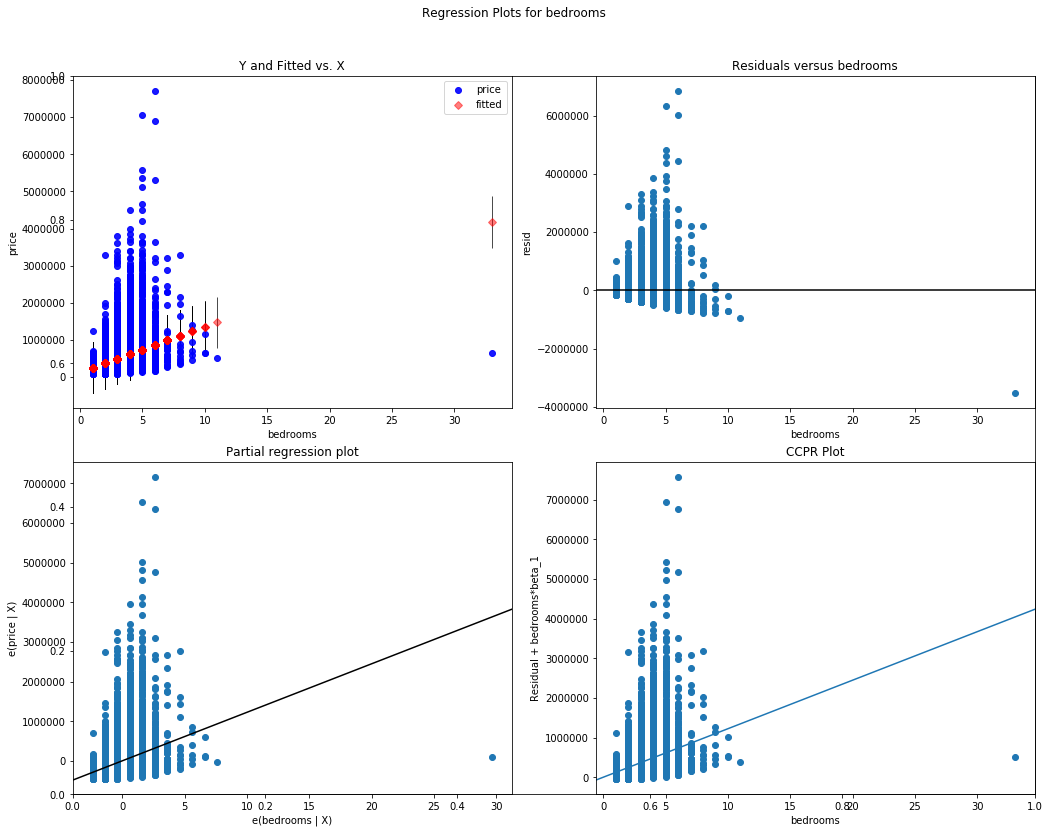

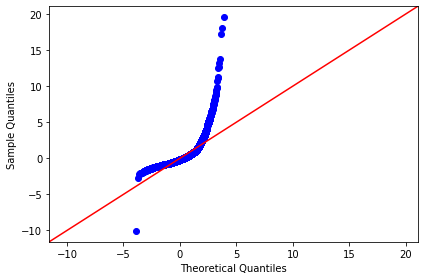

SQFT_LIVING SQFT_LIVING SQFT_LIVING SQFT_LIVING SQFT_LIVING 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_living
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:08:56   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.9

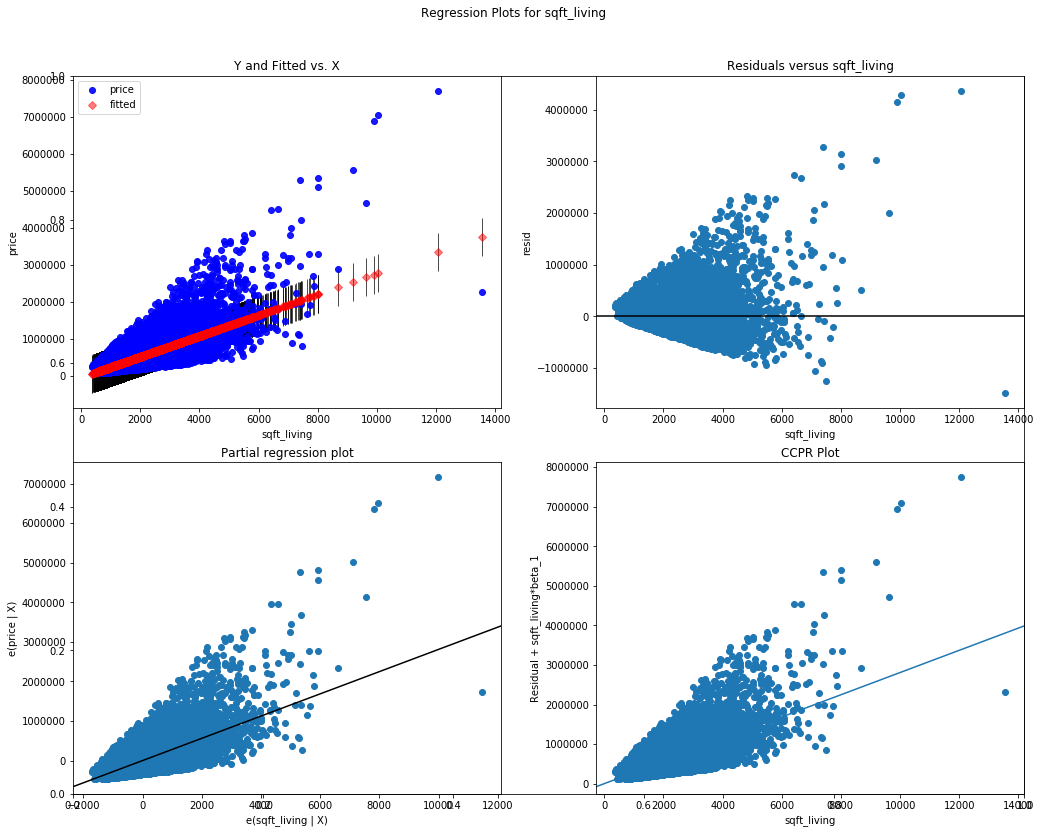

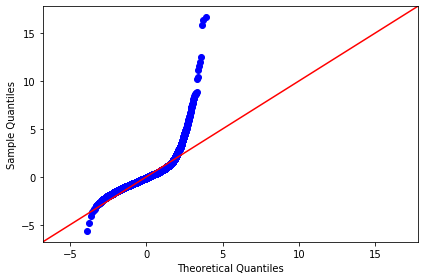

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,bedrooms,0.095350,1.271995e+05,122464.444174,0.0,1.195105e+06
0,grade,0.446158,-1.061416e+06,209157.776072,0.0,2.043899e+06
2,sqft_living,0.492688,-4.398889e+04,280.863014,0.0,5.426626e+05


In [106]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
cols = ['grade', 'bedrooms', 'sqft_living']

results = []
for idx, column in enumerate(cols):
    
    print((column.upper() + " ") * 5)
    print (f"Housing Data - Regression Analysis and Diagnostics for Price~{column}")
    
    f = f'price~{column}'  # create my model formula
    model = smf.ols(formula=f, data=df).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

In [98]:
df[['price', 'view']]

,price,view
0,221900.0,0.0
1,538000.0,0.0
2,180000.0,0.0
3,604000.0,0.0
4,510000.0,0.0
...,...,...
21592,360000.0,0.0
21593,400000.0,0.0
21594,402101.0,0.0
21595,400000.0,0.0
